## 2.3. Equation

In [629]:
cost = pd.read_csv('cost.csv')

cost

,Task ID,Supplier ID,Cost
0,T34,S4,0.307331
1,T34,S5,0.357689
2,T34,S6,0.351982
3,T34,S7,0.303813
4,T34,S8,0.325427
...,...,...,...
7075,T130,S60,0.410605
7076,T130,S61,0.410376
7077,T130,S62,0.407884
7078,T130,S63,0.420536


In [583]:
def calculate_supplier_errors(cost):
    min_cost_per_task = cost.groupby('Task ID')['Cost'].min()

    # Collect task-level details for each supplier
    task_errors_detailed = []

    # Iterate through each supplier
    for supplier in cost['Supplier ID'].unique():
        supplier_costs = cost[cost['Supplier ID'] == supplier]

        # Iterate through each task assigned to this supplier
        for task in supplier_costs['Task ID'].unique():
            # Minimum cost for this task
            min_cost = min_cost_per_task[task]

            # Current supplier's cost for this task
            supplier_cost = supplier_costs[supplier_costs['Task ID'] == task]['Cost'].values[0]

            # Calculate error for this task
            error = min_cost - supplier_cost

            # Add detailed information for this task
            task_errors_detailed.append({
                'Task ID': task,
                'Supplier ID': supplier,
                'Error': error
            })

    # Create a DataFrame for task-level errors
    task_errors_df = pd.DataFrame(task_errors_detailed)

    # Calculate RMSE for each supplier (aggregated)
    rmse_summary = (
        task_errors_df.groupby('Supplier ID')['Error']
        .apply(lambda x: np.sqrt(np.mean(np.square(x))))
        .reset_index()
        .rename(columns={'Error': 'RMSE'})
    )

    return task_errors_df, rmse_summary


In [585]:
calculate_supplier_errors(cost)[0].head()

,Task ID,Supplier ID,Error
0,T34,S4,-0.016363
1,T35,S4,-0.013568
2,T36,S4,-0.069993
3,T3,S4,-0.062062
4,T7,S4,-0.029221


In [587]:
calculate_supplier_errors(cost)[1].head()

,Supplier ID,RMSE
0,S10,0.037401
1,S11,0.033692
2,S12,0.048642
3,S13,0.039451
4,S14,0.043331


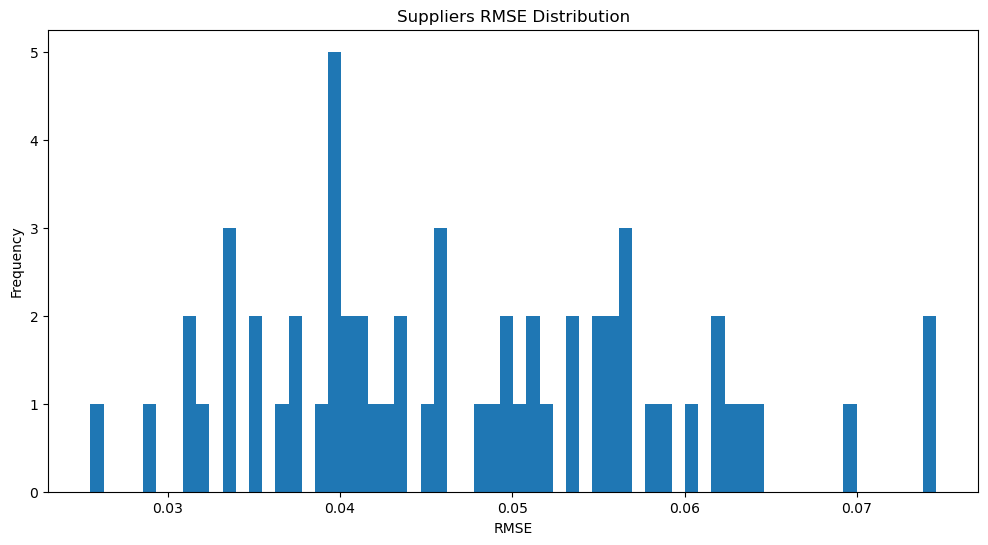

Best 5 suppliers (lowest RMSE):
   Supplier ID      RMSE
46         S56  0.025513
23         S34  0.028830
5          S15  0.030963
22         S33  0.031418
41         S51  0.032154

 Worst 5 suppliers (highest RMSE):
   Supplier ID      RMSE
11         S21  0.074572
48         S58  0.074036
52         S61  0.069511
10         S20  0.063861
15         S25  0.063245


In [599]:
# Visualization
supplier_errors_df = calculate_supplier_errors(cost)[1]

# Histogram
plt.figure(figsize=(12, 6))
plt.hist(supplier_errors_df['RMSE'], bins=64)
plt.title('Suppliers RMSE Distribution')
plt.xlabel('RMSE')
plt.ylabel('Frequency')

plt.show()

# Best/Worst suppliers
print("Best 5 suppliers (lowest RMSE):")
print(supplier_errors_df.nsmallest(5, 'RMSE'))

print("\n Worst 5 suppliers (highest RMSE):")
print(supplier_errors_df.nlargest(5, 'RMSE'))

# 3. ML model fitting and scoring
* ML model fitting and scoring: In this step, you will need to split the data into input features and
output values. In addition, you will create training and testing datasets. One particularity of this
case study is that the same task appears in both training and testing, thus data must be grouped
by task when creating training and validation sets.

## 3.1. Combine data
* Combine the task features, supplier features and costs into a single dataset
* Each Task ID (and its corresponding feature values) will appear multiple times (once for
each supplier). The number of rows of this dataset must be the same as the number of rows
in ‘costs.csv’. Then split the dataset into X (TF1,…,TFn, SF1,…, SFm), y (Cost), and
Groups (Task ID). Note that there will be fewer task features (TFi ) than in the original data
because of the features removed in Step 1 above.

In [397]:
# Import Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

Just using the dataset from the data preparation file

In [400]:
tasks = pd.read_csv('tasks.csv')
suppliers = pd.read_csv('suppliers.csv')
cost = pd.read_csv('cost.csv')

df = pd.read_csv('final_data.csv')
df = df.iloc[:,1:]
df

,Task ID,TF71,TF3,TF87,TF5,TF52,TF64,TF59,TF13,TF25,...,SF14,SF11,SF5,SF16,SF2,SF4,SF15,SF12,SF13,Cost
0,T1,0.03876,0.648543,-0.282124,0.074792,-0.596797,0.185185,0.148936,0.735664,0.718965,...,-0.052632,-0.052632,-0.818182,0.2,-0.052632,-0.818182,-0.538462,0.142857,-0.052632,0.384386
1,T1,0.03876,0.648543,-0.282124,0.074792,-0.596797,0.185185,0.148936,0.735664,0.718965,...,-1.000000,1.000000,1.000000,0.2,-0.052632,1.000000,1.000000,1.000000,1.000000,0.427075
2,T1,0.03876,0.648543,-0.282124,0.074792,-0.596797,0.185185,0.148936,0.735664,0.718965,...,1.000000,1.000000,1.000000,0.2,-1.000000,-1.000000,-0.538462,-1.000000,-1.000000,0.386642
3,T1,0.03876,0.648543,-0.282124,0.074792,-0.596797,0.185185,0.148936,0.735664,0.718965,...,-1.000000,-0.052632,-0.818182,1.0,1.000000,-1.000000,1.000000,0.142857,1.000000,0.392691
4,T1,0.03876,0.648543,-0.282124,0.074792,-0.596797,0.185185,0.148936,0.735664,0.718965,...,1.000000,-1.000000,-1.000000,1.0,-0.052632,-0.818182,-0.538462,0.142857,1.000000,0.434512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7075,T130,1.00000,0.357025,-0.076719,0.064291,-0.474234,-0.629630,-0.702128,0.359876,-0.537758,...,-1.000000,-1.000000,1.000000,0.2,-1.000000,-1.000000,-1.000000,1.000000,-0.052632,0.410605
7076,T130,1.00000,0.357025,-0.076719,0.064291,-0.474234,-0.629630,-0.702128,0.359876,-0.537758,...,1.000000,-0.052632,-1.000000,-1.0,1.000000,-1.000000,-1.000000,-1.000000,-0.052632,0.410376
7077,T130,1.00000,0.357025,-0.076719,0.064291,-0.474234,-0.629630,-0.702128,0.359876,-0.537758,...,-0.052632,-1.000000,1.000000,0.2,-0.052632,-1.000000,-0.538462,1.000000,1.000000,0.407884
7078,T130,1.00000,0.357025,-0.076719,0.064291,-0.474234,-0.629630,-0.702128,0.359876,-0.537758,...,-0.052632,1.000000,1.000000,0.2,-0.052632,-0.818182,1.000000,-1.000000,-1.000000,0.420536


In [402]:
print('The number of rows in the costs dataframe were: ', cost.shape[0], \
      ' and the number of rows of the new dataframe is: ',df.shape[0])

The number of rows in the costs dataframe were:  7080  and the number of rows of the new dataframe is:  7080


Used a manual approach instead of test train split to keep the groups intact

In [405]:
# Splitting into test and train datasets, manually to preserve the groups

X = df.drop(['Task ID','Supplier ID','Cost'], axis='columns')
y = df['Cost']
Groups = df['Task ID']

## 3.2. Train test split
* Randomly select 20 unique ‘Task ID’ values from Groups (let’s call this subset TestGroup).
Split the dataset created in Step 3.1 into four different datasets (X_train, X_test,
y_train and y_test) as follows. X_train, X_test contain only the columns TF1,…,TFn,
SF1,…, SFm; whereas y_train,y_test contain only the column ‘Cost’. Also, X_test,
y_test contain only rows whose Task IDs are in TestGroup; whereas X_train, y_train
contain the remainder rows.

In [408]:
# Randomly select 20 groups
import random
random.seed(42)
TestGroup = random.sample(list(df['Task ID'].unique()), 20)
TestGroup

['T92',
 'T19',
 'T4',
 'T105',
 'T44',
 'T39',
 'T36',
 'T23',
 'T17',
 'T97',
 'T125',
 'T80',
 'T14',
 'T86',
 'T63',
 'T5',
 'T35',
 'T37',
 'T75',
 'T88']

In [410]:
# Also, X_test, y_test contain only rows whose Task IDs are in TestGroup
# whereas X_train, y_train contain the remainder rows

test = df[df['Task ID'].isin(TestGroup)].sort_values(by='Task ID').reset_index(drop=True)
train = df[~df['Task ID'].isin(TestGroup)].sort_values(by='Task ID').reset_index(drop=True)

In [412]:
test

,Task ID,TF71,TF3,TF87,TF5,TF52,TF64,TF59,TF13,TF25,...,SF14,SF11,SF5,SF16,SF2,SF4,SF15,SF12,SF13,Cost
0,T105,1.0,-1.00000,-1.00000,1.000000,-1.000000,1.000000,1.000000,0.324787,-0.805001,...,-0.052632,-0.052632,-1.000000,-1.0,-0.052632,-1.000000,1.000000,1.000000,-0.052632,0.663162
1,T105,1.0,-1.00000,-1.00000,1.000000,-1.000000,1.000000,1.000000,0.324787,-0.805001,...,-1.000000,1.000000,1.000000,1.0,-0.052632,1.000000,1.000000,1.000000,-1.000000,0.661260
2,T105,1.0,-1.00000,-1.00000,1.000000,-1.000000,1.000000,1.000000,0.324787,-0.805001,...,-0.052632,1.000000,-1.000000,-1.0,-0.052632,-0.818182,1.000000,-1.000000,1.000000,0.637136
3,T105,1.0,-1.00000,-1.00000,1.000000,-1.000000,1.000000,1.000000,0.324787,-0.805001,...,-1.000000,1.000000,-0.818182,0.2,1.000000,1.000000,1.000000,1.000000,1.000000,0.655428
4,T105,1.0,-1.00000,-1.00000,1.000000,-1.000000,1.000000,1.000000,0.324787,-0.805001,...,-0.052632,1.000000,1.000000,0.2,-0.052632,-0.818182,-1.000000,0.142857,1.000000,0.661384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,T97,1.0,0.01161,-0.29263,-0.469513,-0.520195,-0.407407,-0.914894,-0.104544,-0.614484,...,-1.000000,-1.000000,-0.818182,1.0,-1.000000,-1.000000,-0.538462,-1.000000,-1.000000,0.425591
1176,T97,1.0,0.01161,-0.29263,-0.469513,-0.520195,-0.407407,-0.914894,-0.104544,-0.614484,...,1.000000,-0.052632,-1.000000,-1.0,-0.052632,1.000000,-0.538462,1.000000,-0.052632,0.495442
1177,T97,1.0,0.01161,-0.29263,-0.469513,-0.520195,-0.407407,-0.914894,-0.104544,-0.614484,...,-1.000000,-1.000000,-0.818182,0.2,1.000000,-0.818182,-0.538462,1.000000,-1.000000,0.499862
1178,T97,1.0,0.01161,-0.29263,-0.469513,-0.520195,-0.407407,-0.914894,-0.104544,-0.614484,...,-0.052632,-0.052632,1.000000,0.2,1.000000,-0.818182,-1.000000,-1.000000,-0.052632,0.467556


In [414]:
print(X_train.shape)
X_test.shape

(5900, 65)


(1180, 65)

In [416]:
len(test['Task ID'].unique())

20

In [418]:
test_loc = df['Task ID'].isin(list(TestGroup))
test_ids = df[test_loc]['Task ID'].to_numpy()

train_ids = df[~test_loc]['Task ID'].to_numpy()
train_tasks = df['Task ID'][~test_loc]

X_test = X[test_loc].to_numpy()
y_test = y[test_loc].to_numpy()
X_train = X[~test_loc].to_numpy()
y_train = y[~test_loc].to_numpy()

Fitting a simple Lasso regression model on the training data, R2 is not very impressive but its not negative so its something!

## 3.3. Train a regression ML model

* Score the performance of the model on the X_test and y_test using the score function of the model. When using a regression model, the ML model predicts the cost of each supplier for a given task, thus the supplier selected by the ML model in Eq. (1) is the one with the lowest predicted cost. Note that Eq. (1) uses the actual cost of the selected supplier, not the predicted cost

### 3.3.1. Lasso
* Lasso Regression (Lasso):
<br>Usage: Uses L1 regularization to perform feature selection.
<br>Pros: Can set coefficients to zero, eliminating unnecessary features.
<br>Cons: Can be computationally intensive with large datasets.

In [423]:
# Fitting Lasso regression model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001, random_state = 42, max_iter = 1000)
lasso.fit(X_train, y_train)

lasso_pred = lasso.predict(X_test)

lasso_score = lasso.score(X_test, y_test)  # R2 score
print('Lasso Score:', lasso_score)

Lasso Score: 0.5812920579314805


### 3.3.2. MLP Regressor

In [426]:
# Fitting MLP regression model

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100,100))
mlp.fit(X_train, y_train)

mlp_pred = mlp.predict(X_test)

mlp_score = mlp.score(X_test, y_test)  # R2 score
print('MLP Score:', mlp_score)

MLP Score: 0.5845061857860527


### 3.3.3. RandomForestRegression

In [428]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 5)
rfr.fit(X_train, y_train)

rfr_pred = rfr.predict(X_test)

rfr_score = rfr.score(X_test, y_test)  # R2 score
print('RandomForestRegressor Score:', rfr_score)

RandomForestRegressor Score: 0.42774452039815236


### 3.3.4. Gradient Boosting Regression

In [430]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
gbr.fit(X_train, y_train)

gbr_pred = gbr.predict(X_test)

gbr_score = gbr.score(X_test, y_test)  # R2 score
print('GradientBoostingRegressor Score:', gbr_score)

GradientBoostingRegressor Score: 0.5038735847334708


## 3.4. Calculate the error

* Using Eq. (1) calculate the Error of the trained model for each task in TestGroup and using
Eq. (2), calculate the RMSE score.

(Charlie) Manuel suggested we should be using numpy instead of pandas for the error functions, apart from that I've tried to keep it simple
rmse_calc is just a useful function to compute our RMSE scores, it doesn't go into the models at all

Error calculation is slightly more involved for the held out part, because the tasks used for testing are all together initially, so we have to split perform it for each task

In [466]:
# Error caculation tables

test_df = test.loc[:,['Task ID', 'Supplier ID', 'Cost']]

# Actual min cost
test_df = test_df.set_index('Task ID')
test_df['Min Cost'] = test_df.groupby('Task ID')['Cost'].min()

# Min cost predicted by ML models
test_df['Predicted Cost_lasso'] = lasso_pred
test_df['Predicted Cost_mlp'] = mlp_pred
test_df['Predicted Cost_rfr'] = rfr_pred
test_df['Predicted Cost_gbr'] = gbr_pred
test_df

,Supplier ID,Cost,Min Cost,Predicted Cost_lasso,Predicted Cost_mlp,Predicted Cost_rfr,Predicted Cost_gbr
Task ID,,,,,,,
T105,S49,0.663162,0.557944,0.377543,0.357384,0.433326,0.426788
T105,S35,0.661260,0.557944,0.380210,0.361690,0.435624,0.429647
T105,S36,0.637136,0.557944,0.377672,0.390761,0.435491,0.430148
T105,S37,0.655428,0.557944,0.375988,0.385197,0.433733,0.429084
T105,S38,0.661384,0.557944,0.380931,0.429804,0.433774,0.437318
...,...,...,...,...,...,...,...
T97,S30,0.425591,0.421872,0.430869,0.426468,0.422999,0.414341
T97,S31,0.495442,0.421872,0.442226,0.454332,0.422999,0.419074
T97,S32,0.499862,0.421872,0.444949,0.394020,0.422999,0.418236


In [542]:
#Sort the values by Task ID and Pred_cost in ascending order to get the cheapest pred_cost
#in order to find the best supplier predicted by machine learning by Task ID
test_df = test_df.sort_values(by=['Task ID','Predicted Cost_lasso','Predicted Cost_mlp',
                                  'Predicted Cost_rfr','Predicted Cost_gbr'],
                              ascending=[True, True, True, True, True])

# Predicted cost list
test_df_list = ['Predicted Cost_lasso','Predicted Cost_mlp',
                'Predicted Cost_rfr','Predicted Cost_gbr']

# Calculate error (selected by ML - min cost)
for i in test_df_list:
    test_df['Error_'+i] = test_df[i] - test_df['Min Cost']

test_df

,Supplier ID,Cost,Min Cost,Predicted Cost_lasso,Predicted Cost_mlp,Predicted Cost_rfr,Predicted Cost_gbr,Error_Predicted Cost_lasso,Error_Predicted Cost_mlp,Error_Predicted Cost_rfr,Error_Predicted Cost_gbr
Task ID,,,,,,,,,,,
T105,S18,0.598734,0.557944,0.371826,0.259513,0.433866,0.424347,-0.186119,-0.298431,-0.124078,-0.133598
T105,S23,0.618557,0.557944,0.373304,0.272115,0.433625,0.412595,-0.184640,-0.285829,-0.124320,-0.145350
T105,S46,0.578902,0.557944,0.373696,0.256462,0.435491,0.423449,-0.184249,-0.301482,-0.122453,-0.134496
T105,S48,0.647156,0.557944,0.374074,0.375124,0.435624,0.433224,-0.183871,-0.182821,-0.122320,-0.124721
T105,S40,0.607061,0.557944,0.374096,0.380314,0.433757,0.426023,-0.183848,-0.177630,-0.124187,-0.131922
...,...,...,...,...,...,...,...,...,...,...,...
T97,S29,0.440674,0.421872,0.443284,0.407600,0.422999,0.412147,0.021412,-0.014273,0.001126,-0.009725
T97,S13,0.455037,0.421872,0.443957,0.430707,0.422999,0.418701,0.022084,0.008834,0.001126,-0.003172
T97,S14,0.431049,0.421872,0.443987,0.445499,0.422999,0.417485,0.022115,0.023626,0.001126,-0.004387


In [544]:
len(test_df.index.unique())

20

In [546]:
result_test = test_df[test_df['Cost'] == test_df['Min Cost']]
result_test

,Supplier ID,Cost,Min Cost,Predicted Cost_lasso,Predicted Cost_mlp,Predicted Cost_rfr,Predicted Cost_gbr,Error_Predicted Cost_lasso,Error_Predicted Cost_mlp,Error_Predicted Cost_rfr,Error_Predicted Cost_gbr
Task ID,,,,,,,,,,,
T105,S33,0.557944,0.557944,0.374288,0.356736,0.435084,0.415247,-0.183657,-0.201209,-0.122861,-0.142698
T125,S64,0.374692,0.374692,0.455892,0.394677,0.447755,0.465636,0.081200,0.019984,0.073063,0.090944
T14,S15,0.301029,0.301029,0.349804,0.340641,0.351699,0.344291,0.048775,0.039612,0.050670,0.043263
T17,S56,0.321380,0.321380,0.365985,0.350796,0.365448,0.359662,0.044605,0.029416,0.044068,0.038282
T19,S49,0.309074,0.309074,0.362537,0.337839,0.347444,0.341057,0.053463,0.028765,0.038370,0.031983
T23,S15,0.305738,0.305738,0.339113,0.310166,0.360146,0.352502,0.033375,0.004428,0.054408,0.046764
T35,S19,0.283752,0.283752,0.407108,0.334740,0.350566,0.352164,0.123357,0.050988,0.066814,0.068413
T36,S46,0.284575,0.284575,0.374752,0.376945,0.380723,0.366419,0.090177,0.092370,0.096148,0.081844
T37,S15,0.307787,0.307787,0.356419,0.365175,0.351191,0.343085,0.048632,0.057388,0.043404,0.035298


In [548]:
print('RMSE by Eq.(2): ')
# RMSE score
# Predicted cost error
result_test_list = result_test.loc[:,['Error_Predicted Cost_lasso','Error_Predicted Cost_mlp',
                    'Error_Predicted Cost_rfr','Error_Predicted Cost_gbr']]
ML_model = ['Lasso', 'MLP', 'RandomForestRegressor', 'GradientBoostingRegressor']
RMSE = []

# Calculate error (selected by ML - min cost)
for i, j in zip(result_test_list, ML_model):
    result_test['Squared_'+j] = result_test[i]**2
    mse = np.sum(result_test['Squared_'+j])/len(result_test.index.unique())
    rmse = np.sqrt(mse)
    
    print(f'RMSE {j}: {rmse}')
    RMSE.append(rmse)

RMSE by Eq.(2): 
RMSE Lasso: 0.07218516990158398
RMSE MLP: 0.10016106731360437
RMSE RandomForestRegressor: 0.06284740513161087
RMSE GradientBoostingRegressor: 0.06171221608599646


/var/folders/h6/v1myh0ps1tz0jbv6g8_vkhqw0000gn/T/ipykernel_68792/3107055408.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_test['Squared_'+j] = result_test[i]**2
/var/folders/h6/v1myh0ps1tz0jbv6g8_vkhqw0000gn/T/ipykernel_68792/3107055408.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_test['Squared_'+j] = result_test[i]**2
/var/folders/h6/v1myh0ps1tz0jbv6g8_vkhqw0000gn/T/ipykernel_68792/3107055408.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [550]:
result_test

,Supplier ID,Cost,Min Cost,Predicted Cost_lasso,Predicted Cost_mlp,Predicted Cost_rfr,Predicted Cost_gbr,Error_Predicted Cost_lasso,Error_Predicted Cost_mlp,Error_Predicted Cost_rfr,Error_Predicted Cost_gbr,Squared_Lasso,Squared_MLP,Squared_RandomForestRegressor,Squared_GradientBoostingRegressor
Task ID,,,,,,,,,,,,,,,
T105,S33,0.557944,0.557944,0.374288,0.356736,0.435084,0.415247,-0.183657,-0.201209,-0.122861,-0.142698,3.372981e-02,0.040485,0.015095,0.020363
T125,S64,0.374692,0.374692,0.455892,0.394677,0.447755,0.465636,0.081200,0.019984,0.073063,0.090944,6.593407e-03,0.000399,0.005338,0.008271
T14,S15,0.301029,0.301029,0.349804,0.340641,0.351699,0.344291,0.048775,0.039612,0.050670,0.043263,2.378997e-03,0.001569,0.002567,0.001872
T17,S56,0.321380,0.321380,0.365985,0.350796,0.365448,0.359662,0.044605,0.029416,0.044068,0.038282,1.989595e-03,0.000865,0.001942,0.001466
T19,S49,0.309074,0.309074,0.362537,0.337839,0.347444,0.341057,0.053463,0.028765,0.038370,0.031983,2.858314e-03,0.000827,0.001472,0.001023
T23,S15,0.305738,0.305738,0.339113,0.310166,0.360146,0.352502,0.033375,0.004428,0.054408,0.046764,1.113909e-03,0.000020,0.002960,0.002187
T35,S19,0.283752,0.283752,0.407108,0.334740,0.350566,0.352164,0.123357,0.050988,0.066814,0.068413,1.521694e-02,0.002600,0.004464,0.004680
T36,S46,0.284575,0.284575,0.374752,0.376945,0.380723,0.366419,0.090177,0.092370,0.096148,0.081844,8.131878e-03,0.008532,0.009244,0.006698
T37,S15,0.307787,0.307787,0.356419,0.365175,0.351191,0.343085,0.048632,0.057388,0.043404,0.035298,2.365044e-03,0.003293,0.001884,0.001246


In [552]:
# For just Reference  (We can delete it!)

print('RMSE by sklearn: ')
from sklearn.metrics import root_mean_squared_error

lasso_rmse = mean_squared_error(y_test, lasso_pred)
mlp_rmse = mean_squared_error(y_test, mlp_pred)
rfr_rmse = mean_squared_error(y_test, rfr_pred)
gbr_rmse = mean_squared_error(y_test, gbr_pred)

print('lasso_rmse', lasso_rmse)
print('mlp_rmse', mlp_rmse)
print('rfr_rmse', rfr_rmse)
print('gbr_rmse', gbr_rmse)

RMSE by sklearn: 
lasso_rmse 0.002421673293974191
mlp_rmse 0.0024030838028114886
rfr_rmse 0.0033097433151994165
gbr_rmse 0.0028694370695492824


## 3.5. Compare Errors and RMSE
* Compare to the values obtained in Step 2.3 and summarise your
conclusions.

In [621]:
error1 = calculate_supplier_errors_detailed(cost)[0]
error1 = error1[error1['Task ID'].isin(TestGroup)]
error1

,Task ID,Supplier ID,Error
1,T35,S4,-0.013568
2,T36,S4,-0.069993
9,T17,S4,-0.050688
10,T19,S4,-0.001723
14,T14,S4,-0.043663
...,...,...,...
7037,T88,S64,-0.041824
7041,T92,S64,-0.016629
7046,T97,S64,-0.028612
7054,T105,S64,-0.001848


241216 여기부터 다시 해야함 (Sorry for using Korean, I'd like to find the last code easily)

<function matplotlib.pyplot.show(close=None, block=None)>

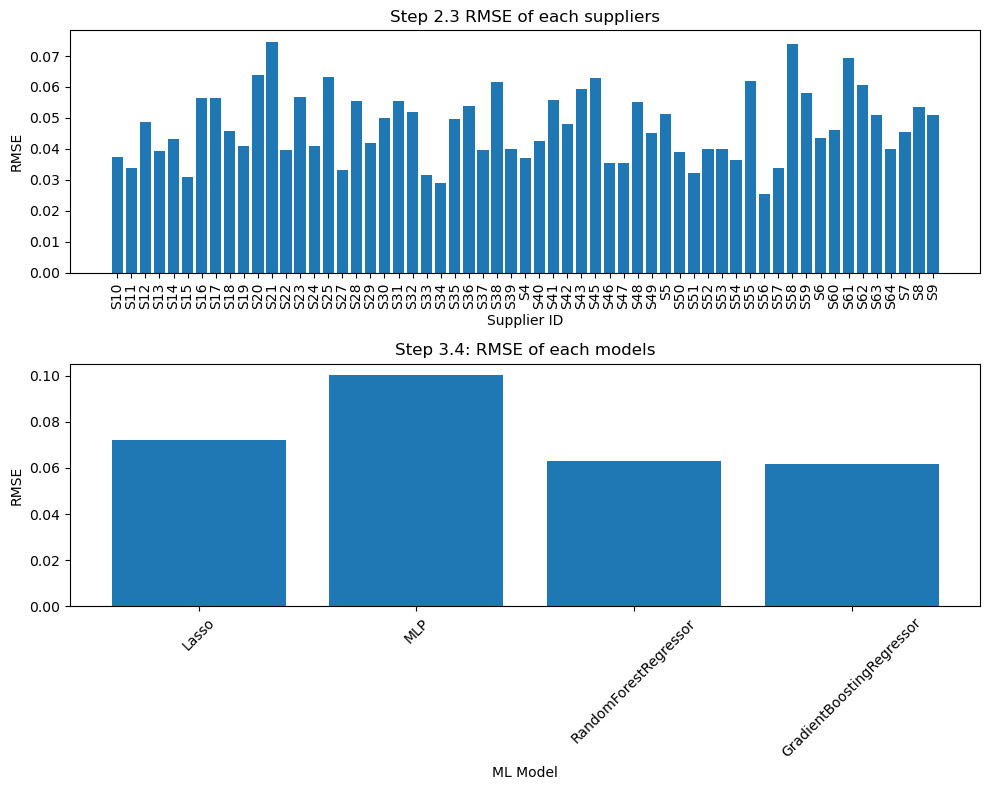

In [607]:
suppliers_rmse_step2_3 = calculate_supplier_errors(cost)[1]

models_rmse_step3_4 = {
    'Lasso': RMSE[0],
    'MLP': RMSE[1],
    'RandomForestRegressor': RMSE[2],
    'GradientBoostingRegressor': RMSE[3]}

# Visualization
plt.figure(figsize=(10, 8))

# 2.3 RMSE
plt.subplot(2, 1, 1)
plt.bar(suppliers_rmse_step2_3['Supplier ID'], suppliers_rmse_step2_3['RMSE'])
plt.title('Step 2.3 RMSE of each suppliers')
plt.xlabel('Supplier ID')
plt.ylabel('RMSE')
plt.xticks(rotation=90)

# 3.4 RMSE (based on ML models)
plt.subplot(2, 1, 2)
plt.bar(list(models_rmse_step3_4.keys()), list(models_rmse_step3_4.values()))
plt.title('Step 3.4: RMSE of each models')
plt.xlabel('ML Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show

In [ ]:

# Comparison statistically
print("Step 2.3 - RMSE:")
print(suppliers_rmse_step2_3['RMSE'].describe())

print("\nStep 3.4 - ML RMSE:")
for model, rmse in models_rmse_step3_4.items():
    print(f"{model}: {rmse}")

# Calculating improvement
best_supplier_rmse = suppliers_rmse_step2['RMSE'].min()
improvement_percentages = {}

for model, model_rmse in models_rmse_step3.items():
    improvement = (best_supplier_rmse - model_rmse) / best_supplier_rmse * 100
    improvement_percentages[model] = improvement

print("Improvement:")
for model, improvement in improvement_percentages.items():
    print(f"{model}: {improvement:.2f}%")

Here we make a scorer out of our error function, since the validation set is all one task (for each fold) it is fairly simple to apply now

In [142]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.metrics import make_scorer

logo = LeaveOneGroupOut()
error_scorer = make_scorer(error_function)

lasso_cv = Lasso(alpha=0.001)
cv_scores = cross_val_score(lasso_cv, X_train, y_train, cv=logo, groups=train_tasks, scoring=error_scorer)

I think the error goes up because we're only using part of the training data in each fold, hopefully it's nothing to worry about

In [144]:
print(rmse_calc(cv_scores))

0.032439356868181835


We only see predictive accuracy of any kind with tiny alpha values, but it does form a ranking which is the main thing
Takes about 5 minutes to run for me, so bear that in mind

In [148]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

lasso_hp = Lasso()
params = {'alpha': np.linspace(0.001, 0.0001, 100)}

grid_search = GridSearchCV(lasso_hp, param_grid=params, scoring=error_scorer, cv=logo, n_jobs=-1)
grid_search.fit(X_train, y_train, groups=train_tasks)
lasso_hp_results = pd.DataFrame(grid_search.cv_results_)

Picks out a very very small alpha value, but at least it picks one

In [150]:
print(grid_search.best_params_)

{'alpha': 0.00037272727272727273}


Next job is report to fit the model for the chosen hyperparameters, report the rmse, copy paste the code for a new regression model, maybe MLP? and get some simple viz of the results

In [154]:
grid_search.best_params_['alpha']

0.00037272727272727273

In [156]:
lasso_hp = Lasso(alpha=grid_search.best_params_['alpha'])
lasso_hp.fit(X_train, y_train)
print(lasso_hp.score(X_test,y_test))
y_pred = lasso_hp.predict(X_test)

0.5462614126570942


In [158]:
hp_errors = []
for i in TestGroup:
    task_trues = y_test[test_ids == i]
    task_preds = y_pred[test_ids == i]
    hp_errors.append(error_function(task_trues, task_preds))
    print(error_function(task_trues, task_preds))

-0.023997590206996378
-0.01886495931830251
-0.018176695386359243
-0.006408969222048588
-0.011245950423476758
-0.0104726223705211
-0.02762685539882359
-0.033259263796944605
0.0
-0.007138839421870102
-0.025453823409779752
-0.0345263004921727
-0.010408508583130804
-0.019862313243964813
-0.0333538663567397
0.0
-0.010170413261649969
-0.0006968233468558904
-0.05661013824413952
-0.019587667953720522


In [160]:
print(rmse_calc(hp_errors))

0.02302972973273373


We see a pretty big improvement on our initital alpha choice, thank god!

Now we're repeating the process for MLP, the code is completely symmetrical to the Lasso case except for the parameters

In [164]:
# 3.3 Fitting an MLP regression model
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100,100))
mlp.fit(X_train, y_train)
print(mlp.score(X_test,y_test))
y_pred = mlp.predict(X_test)

0.1962823294782805


In [166]:
mlp_h_o_errors = []
for i in TestGroup:
    task_trues = y_test[test_ids == i]
    task_preds = y_pred[test_ids == i]
    mlp_h_o_errors.append(error_function(task_trues, task_preds))
    print(error_function(task_trues, task_preds))

print(rmse_calc(mlp_h_o_errors))

-0.025894681877737302
-0.030271842966113183
-0.030514605516835935
-0.006408969222048588
-0.011426437843547299
-0.03660749074221148
-0.021544021713750916
-0.05801817496592848
-0.025440561555003904
0.0
-0.015614183915045654
-0.06547873147302269
-0.02181652419831842
-0.021210992012478613
-0.01823508720918121
-0.03743738262150048
-0.024029883872227098
-0.001982766080626086
-0.04302513198576374
-0.018625472939890086
0.03039566535358474


In [168]:
logo = LeaveOneGroupOut()
error_scorer = make_scorer(error_function)

mlp_cv = MLPRegressor(hidden_layer_sizes=(100,100))
cv_scores = cross_val_score(mlp_cv, X_train, y_train, cv=logo, groups=train_tasks, scoring=error_scorer)

In [170]:
print(rmse_calc(cv_scores))

0.0320612509829627


Works but maybe would change the hidden layer sizes we offer, don't get a very big performance improvement

In [173]:
mlp_hp = MLPRegressor()
params = {'hidden_layer_sizes': [(100,100),(50,50,50),(200)],
          'solver': ['lbfgs', 'sgd', 'adam']}

grid_search_mlp = GridSearchCV(mlp_hp, param_grid=params, scoring=error_scorer, cv=logo, n_jobs=-1)
grid_search_mlp.fit(X_train, y_train, groups=train_tasks)
mlp_hp_results = pd.DataFrame(grid_search_mlp.cv_results_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [175]:
print(grid_search_mlp.best_params_)

{'hidden_layer_sizes': 200, 'solver': 'lbfgs'}


In [177]:
mlp_hp = MLPRegressor(hidden_layer_sizes=grid_search_mlp.best_params_['hidden_layer_sizes'],
                      solver=grid_search_mlp.best_params_['solver'])
mlp_hp.fit(X_train, y_train)
print(mlp_hp.score(X_test,y_test))
y_pred = mlp_hp.predict(X_test)

0.6072991443863579


In [179]:
mlp_hp_errors = []
for i in TestGroup:
    task_trues = y_test[test_ids == i]
    task_preds = y_pred[test_ids == i]
    mlp_hp_errors.append(error_function(task_trues, task_preds))
    print(error_function(task_trues, task_preds))

-0.016181261818858483
-0.020898605623685618
-0.018176695386359243
-0.013550131502406582
-0.029796021793397964
-0.03275120473185139
-0.015991979187916894
-0.033259263796944605
-0.013177836730864811
0.0
-0.021170850114500872
-0.0713267179265189
-0.010408508583130804
0.0
-0.018833061948957452
-0.03743738262150048
-0.01276878248146518
-0.0006968233468558904
-0.04302513198576374
-0.02391103784115678


In [181]:
print(rmse_calc(mlp_hp_errors))

0.02710656429823698
